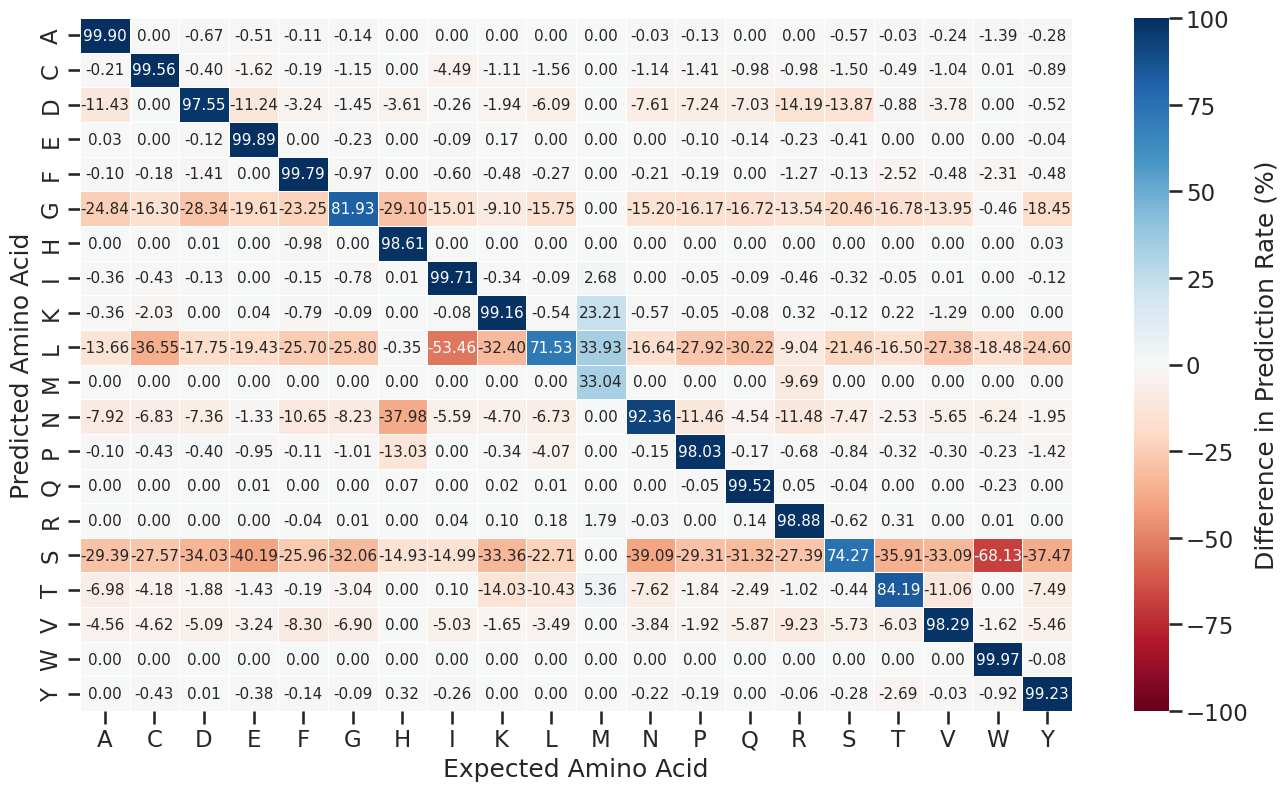

In [ ]:
import os
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

def generate_heatmap_comp(log_dir1: str, log_dir2: str, epoch1: int, epoch2: int):
    """
    Amino acid prediction heatmap (only single epoch data, aggregated across ranks).
    """
    def calculate_heatmap_data(aa_preds_dir: str, epoch: int):
        ALL_AAS = 'ACDEFGHIKLMNPQRSTVWY'
        all_combinations = [(e_aa, p_aa) for e_aa in ALL_AAS for p_aa in ALL_AAS]
        all_df = pd.DataFrame(all_combinations, columns=["Expected", "Predicted"])

        # Aggregate counts for current epoch
        total_data = defaultdict(int)  # key: "Expected->Predicted", value: total count

        for rank in range(8):
            csv_path = os.path.join(aa_preds_dir, f"aa_predictions_epoch{epoch}_rank{rank}.csv")
            if not os.path.exists(csv_path):
                continue

            df = pd.read_csv(csv_path)
            for _, row in df.iterrows():
                key = row['expected_aa->predicted_aa']
                count = int(row['count'])
                total_data[key] += count

        # Convert dict to DataFrame
        records = []
        for aa_pair, count in total_data.items():
            expected, predicted = aa_pair.split('->')
            records.append({'Expected': expected, 'Predicted': predicted, 'Total Count': count})

        agg_df = pd.DataFrame(records)

        # Merge with all combinations to fill in missing zero entries
        df = pd.merge(all_df, agg_df, how="left", on=["Expected", "Predicted"])
        df["Total Count"] = df["Total Count"].fillna(0)

        # Compute expected totals and error percentage
        expected_totals = df.groupby("Expected")["Total Count"].sum()
        df["Expected Total"] = df["Expected"].map(expected_totals)
        df["Error Percentage"] = (df["Total Count"] / df["Expected Total"]) * 100
        df["Error Percentage"] = df["Error Percentage"].fillna(0)

        # Pivot for heatmap
        heatmap_data = df.pivot_table(index="Predicted", columns="Expected", values="Error Percentage")
        return heatmap_data

    # Calculate heatmap data for both models
    aa_preds_dir1 = os.path.join(log_dir1, "aa_preds")
    heatmap_data1 = calculate_heatmap_data(aa_preds_dir1, epoch1)

    aa_preds_dir2 = os.path.join(log_dir2, "aa_preds")
    heatmap_data2 = calculate_heatmap_data(aa_preds_dir2, epoch2)

    # Subtract heatmap 1 from heatmap 2 to create the difference heatmap
    subtractive_heatmap_data = heatmap_data2 - heatmap_data1

    # Plot heatmap
    sns.set_style('ticks')
    sns.set_context('talk')
    plt.figure(figsize=(16, 9))

    heatmap = sns.heatmap(
        subtractive_heatmap_data,
        annot=True, fmt=".2f",
        linewidth=.5,
        cmap="RdBu", vmin=-100, vmax=100,
        annot_kws={"size": 11},
        cbar_kws={'drawedges': False, 'label': 'Difference in Prediction Rate (%)'}
    )

    plt.xlabel('Expected Amino Acid')
    plt.ylabel('Predicted Amino Acid')

    # Save the figure
    save_path = f"heatmap/aa_predictions_heatmap_comp-esm_mlm"
    plt.savefig(f"{save_path}.pdf", format='pdf', dpi=300, bbox_inches='tight')
    plt.savefig(f"{save_path}.png", format='png', dpi=300, bbox_inches='tight')
    plt.show()

generate_heatmap_comp(
    log_dir1 = "../../src/pnlp/ESM_MLM/logs/version_21819650",
    log_dir2 = "../../src/pnlp/ESM_MLM/logs/version_21768307",
    epoch1 = 0,
    epoch2 = 73
)

Above is heatmap comparison between fine-tuned ESM MLM and non fine-tuned ESM MLM models.